**Librerias y df**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "../resultados/benchmark_results.csv"

column_names = ["n", "mode", "threads_or_gridsize", "time"]
df = pd.read_csv(csv_path, header=None, names=column_names)

df.columns = df.columns.str.strip()

**Grafico a) Tiempo (y) vs n (x)**


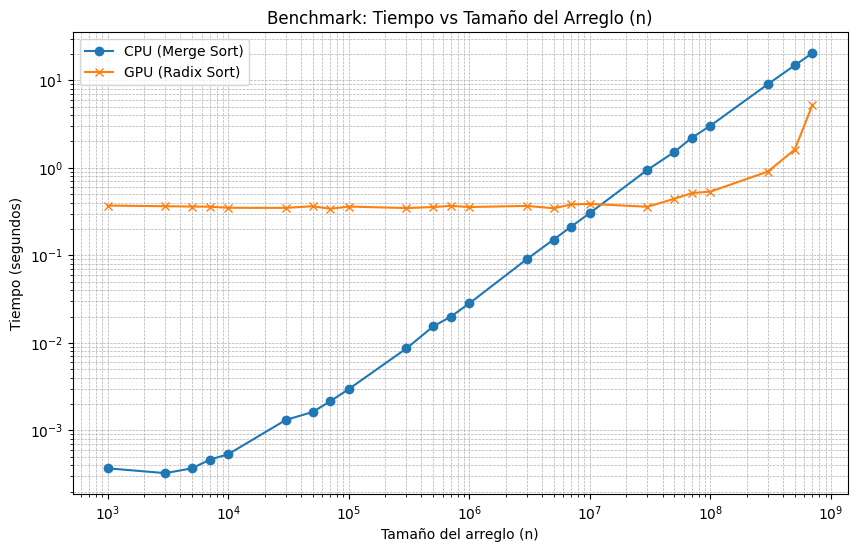

In [ ]:
# promedio de los tiempos por configuracion (agrupando por n y mode)
df_avg = df.groupby(["n", "mode", "threads_or_gridsize"])["time"].mean().reset_index()


cpu_data = df_avg[(df_avg["n"] < 1000000000) & (df_avg["mode"] == 0) & (df_avg["threads_or_gridsize"] == 8)]
gpu_data = df_avg[(df_avg["n"] < 1000000000) & (df_avg["mode"] == 1) & (df_avg["threads_or_gridsize"] == 256)]

plt.figure(figsize=(10, 6))
plt.plot(cpu_data["n"], cpu_data["time"], label="CPU (Merge Sort)", marker="o")
plt.plot(gpu_data["n"], gpu_data["time"], label="GPU (Radix Sort)", marker="x")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Tamaño del arreglo (n)")
plt.ylabel("Tiempo (segundos)")
plt.title("Benchmark: Tiempo vs Tamaño del Arreglo (n)")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
#plt.savefig("../resultados/benchmark_a.png")
plt.show()


**Grafico b) [Solo CPU] Speedup y vs num-threads (x)**

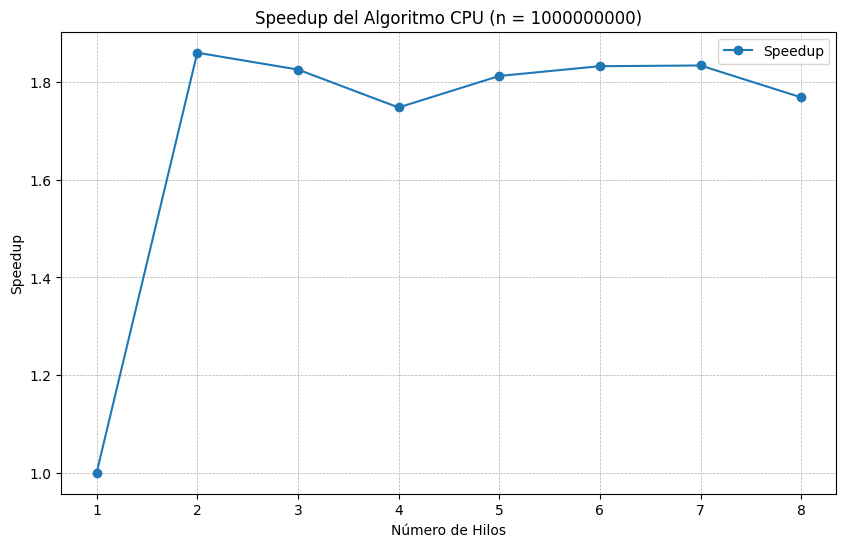

In [ ]:

# filtrar datos para CPU (mode = 0) y un tamaño de problema fijo (e.g., n = 100000000)
n_fixed = df["n"].max()  # el n más grande como referencia
df_fixed = df[(df["mode"] == 0) & (df["n"] == n_fixed)]

# promedio de  tiempos por número de hilos
df_avg = df_fixed.groupby("threads_or_gridsize")["time"].mean().reset_index()

# calcular el tiempo con 1 hilo (base para el speedup)
base_time = df_avg[df_avg["threads_or_gridsize"] == 1]["time"].values[0]

# calcular el speedup
df_avg["speedup"] = base_time / df_avg["time"]

# grafico Speedup vs numero de hilos
plt.figure(figsize=(10, 6))
plt.plot(df_avg["threads_or_gridsize"], df_avg["speedup"], marker="o", label="Speedup")
plt.xlabel("Número de Hilos")
plt.ylabel("Speedup")
plt.title(f"Speedup del Algoritmo CPU (n = {n_fixed})")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.xticks(range(1, df_avg["threads_or_gridsize"].max() + 1))
plt.legend()
#plt.savefig("../resultados/benchmark_b.png")
plt.show()


**Grafico b) [Solo CPU] Eficiencia paralela y vs num-threads (x)**

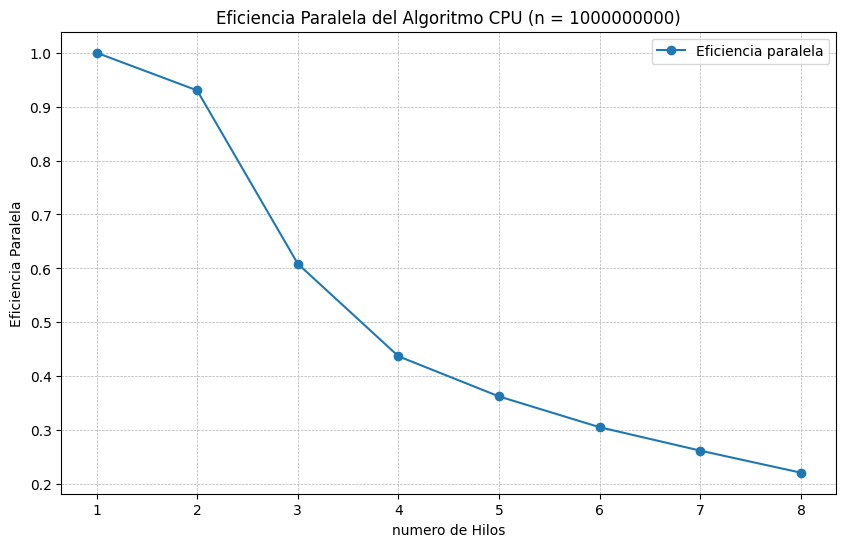

In [4]:
# filtrar datos para CPU (mode = 0) y un tamaño de problema fijo (e.g., n = 100000000)
n_fixed = df["n"].max() 
df_fixed = df[(df["mode"] == 0) & (df["n"] == n_fixed)]

# promedio de  tiempos por numero de hilos
df_avg = df_fixed.groupby("threads_or_gridsize")["time"].mean().reset_index()

# caclular el tiempo con 1 hilo (base para el speedup)
base_time = df_avg[df_avg["threads_or_gridsize"] == 1]["time"].values[0]

# calcular el speedup
df_avg["speedup"] = base_time / df_avg["time"]

# calcular la eficiencia paralela
df_avg["efficiency"] = df_avg["speedup"] / df_avg["threads_or_gridsize"]

# grafico Eficiencia vs numero de hilos
plt.figure(figsize=(10, 6))
plt.plot(df_avg["threads_or_gridsize"], df_avg["efficiency"], marker="o", label="Eficiencia paralela")
plt.xlabel("numero de Hilos")
plt.ylabel("Eficiencia Paralela")
plt.title(f"Eficiencia Paralela del Algoritmo CPU (n = {n_fixed})")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.xticks(range(1, df_avg["threads_or_gridsize"].max() + 1))
plt.legend()
#plt.savefig("../resultados/benchmark_c.png")
plt.show()


**Grafico d) [Solo GPU] Speedup y vs num-bloques (x)** 

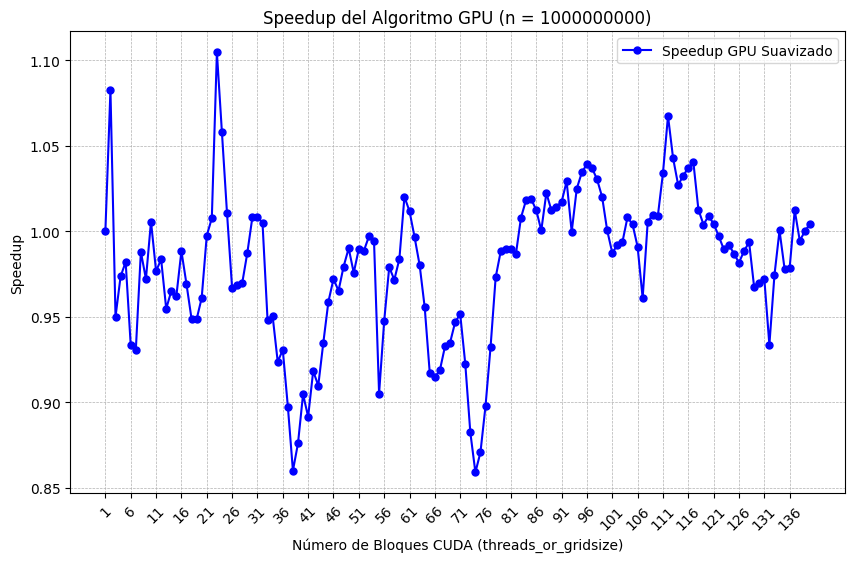

In [5]:
df_gpu = df[df["mode"] == 1]


n_fixed = df_gpu["n"].max()


df_fixed_gpu = df_gpu[df_gpu["n"] == n_fixed]

df_fixed_gpu = df_fixed_gpu[(df_fixed_gpu["threads_or_gridsize"] >= 1) & (df_fixed_gpu["threads_or_gridsize"] <= 140)]

# promedio los tiempos por número de bloques o threads
df_avg_gpu = df_fixed_gpu.groupby("threads_or_gridsize")["time"].mean().reset_index()

# ver si hay un registro con threads_or_gridsize == 1
if 1 in df_avg_gpu["threads_or_gridsize"].values:
    # calcular el tiempo con 1 bloque (base para el speedup)
    base_time = df_avg_gpu[df_avg_gpu["threads_or_gridsize"] == 1]["time"].values[0]
else:
    print("No se encontró un registro con threads_or_gridsize == 1. Usando el tiempo con el valor más bajo.")
    # si 1 no está, se usa el valor mas cercano a 1 (el menor disponible)
    base_time = df_avg_gpu["time"].min()

# calcular speedup
df_avg_gpu["speedup"] = base_time / df_avg_gpu["time"]

# suavizar el speedup usando una media movil (ventana de 5)
df_avg_gpu['smoothed_speedup'] = df_avg_gpu['speedup'].rolling(window=5, min_periods=1).mean()

# speedup vs nimero de Bloques
plt.figure(figsize=(10, 6))
plt.plot(df_avg_gpu["threads_or_gridsize"], df_avg_gpu["smoothed_speedup"], marker="o", markersize=5, color='b', label="Speedup GPU Suavizado")
#plt.axhline(y=1, color='r', linestyle='--', label="Speedup Ideal")  # Línea de referencia para el speedup ideal
plt.xlabel("Número de Bloques CUDA (threads_or_gridsize)")
plt.ylabel("Speedup")
plt.title(f"Speedup del Algoritmo GPU (n = {n_fixed})")
plt.grid(True, linestyle="--", linewidth=0.5)


plt.xticks(df_avg_gpu["threads_or_gridsize"].astype(int)[::5])

plt.xticks(rotation=45)

plt.legend()
#plt.savefig("../resultados/benchmark_d.png")
plt.show()

**Grafico e) [Solo GPU] Eficiencia paralela y vs num-bloques (x)**

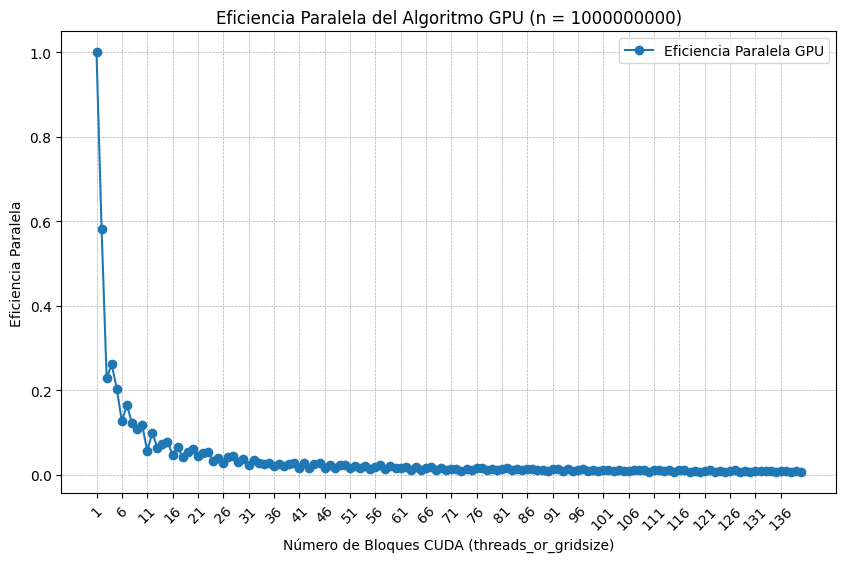

In [6]:
#  solo datos para GPU (mode == 1)
df_gpu = df[df["mode"] == 1]

n_fixed = df_gpu["n"].max()

# filtro de  los datos para ese tamaño de problema
df_fixed_gpu = df_gpu[df_gpu["n"] == n_fixed]

df_fixed_gpu = df_fixed_gpu[(df_fixed_gpu["threads_or_gridsize"] >= 1) & (df_fixed_gpu["threads_or_gridsize"] <= 140)]

# promedio de los tiempos por numero de bloques o threads
df_avg_gpu = df_fixed_gpu.groupby("threads_or_gridsize")["time"].mean().reset_index()

# verificar si hay un registro con threads_or_gridsize == 1
if 1 in df_avg_gpu["threads_or_gridsize"].values:
    # calcular el tiempo con 1 bloque (base para el speedup)
    base_time = df_avg_gpu[df_avg_gpu["threads_or_gridsize"] == 1]["time"].values[0]
else:
    print("No se encontró un registro con threads_or_gridsize == 1. Usando el tiempo con el valor más bajo.")
    base_time = df_avg_gpu["time"].min()

# calcular el speedup
df_avg_gpu["speedup"] = base_time / df_avg_gpu["time"]

# calcular la eficiencia paralela
df_avg_gpu["efficiency"] = df_avg_gpu["speedup"] / df_avg_gpu["threads_or_gridsize"]

# grafico de  Eficiencia Paralela vs numero de Bloques
plt.figure(figsize=(10, 6))
plt.plot(df_avg_gpu["threads_or_gridsize"], df_avg_gpu["efficiency"], marker="o", label="Eficiencia Paralela GPU")
plt.xlabel("Número de Bloques CUDA (threads_or_gridsize)")
plt.ylabel("Eficiencia Paralela")
plt.title(f"Eficiencia Paralela del Algoritmo GPU (n = {n_fixed})")
plt.grid(True, linestyle="--", linewidth=0.5)

# ajustar los ticks del eje X para que comiencen desde 1
plt.xticks(df_avg_gpu["threads_or_gridsize"].astype(int)[::5])

# rotar las etiquetas del eje X para mejorar la legibilidad
plt.xticks(rotation=45)

plt.legend()
#plt.savefig("../resultados/benchmark_e.png")
plt.show()


**Grafico f) Speedup vs n** 

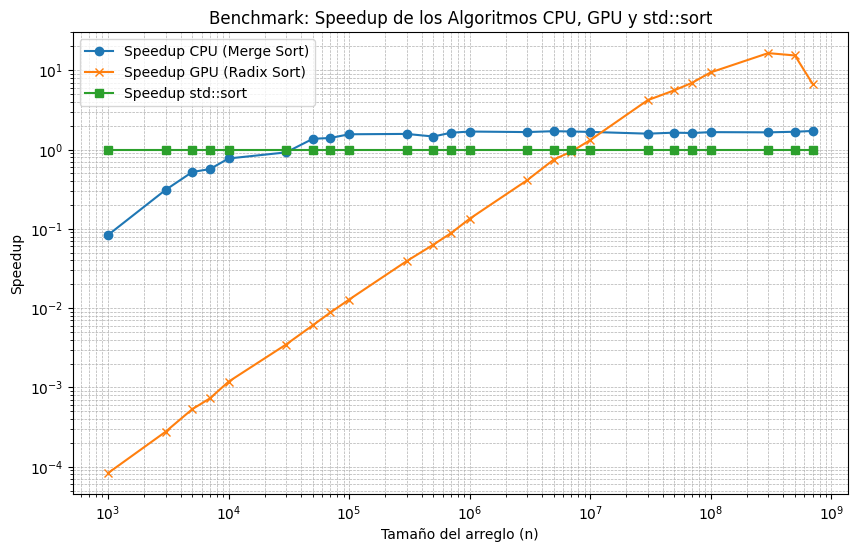

In [7]:
# promedio de los tiempos por configuración (agrupando por n y mode)
df_avg = df.groupby(["n", "mode", "threads_or_gridsize"])["time"].mean().reset_index()

# filtro para GPU, CPU y std::sort (tamaños de n menores a 1,000,000,000)
gpu_data = df_avg[(df_avg["n"] < 1000000000) & (df_avg["mode"] == 1)]
cpu_data = df_avg[(df_avg["n"] < 1000000000) & (df_avg["mode"] == 0)]
stl_sort_data = df_avg[(df_avg["n"] < 1000000000) & (df_avg["mode"] == 2)]

# listas para almacenar el speedup de CPU y GPU con respecto a std::sort
speedup_cpu = []
speedup_gpu = []
speedup_sort = []

# iterar los diferentes tamaños de n en los DataFrames filtrados
for n_value in gpu_data["n"].unique():  # se usan los valores únicos de 'n' de los datos de GPU (todos deben tener el mismo rango)
    # tiempo de std::sort para cada n
    stl_sort_row = stl_sort_data[stl_sort_data["n"] == n_value]
    if len(stl_sort_row) > 0:
        time_sort = stl_sort_row["time"].values[0]
    else:
        print(f"Advertencia: No se encontraron datos para std::sort con n = {n_value}")
        continue 

    #tiempo de CPU para el mismo n
    cpu_row = cpu_data[cpu_data["n"] == n_value]
    if len(cpu_row) > 0:
        time_cpu = cpu_row["time"].values[0]
    else:
        print(f"Advertencia: No se encontraron datos para CPU con n = {n_value}")
        continue  

    # tiempo de GPU para el mismo n
    gpu_row = gpu_data[gpu_data["n"] == n_value]
    if len(gpu_row) > 0:
        time_gpu = gpu_row["time"].values[0]
    else:
        print(f"Advertencia: No se encontraron datos para GPU con n = {n_value}")
        continue  

    # speedup para CPU y GPU con respecto a std::sort
    speedup_cpu_value = time_sort / time_cpu
    speedup_gpu_value = time_sort / time_gpu
    speedup_sort_value = 1  # El speedup de std::sort con respecto a sí mismo es 1

    # Almacenar los resultados de speedup
    speedup_cpu.append([n_value, speedup_cpu_value])
    speedup_gpu.append([n_value, speedup_gpu_value])
    speedup_sort.append([n_value, speedup_sort_value])

# pasar las listas a DataFrames para graficar
df_speedup_cpu = pd.DataFrame(speedup_cpu, columns=["n", "speedup_cpu"])
df_speedup_gpu = pd.DataFrame(speedup_gpu, columns=["n", "speedup_gpu"])
df_speedup_sort = pd.DataFrame(speedup_sort, columns=["n", "speedup_sort"])


plt.figure(figsize=(10, 6))
plt.plot(df_speedup_cpu["n"], df_speedup_cpu["speedup_cpu"], label="Speedup CPU (Merge Sort)", marker="o")
plt.plot(df_speedup_gpu["n"], df_speedup_gpu["speedup_gpu"], label="Speedup GPU (Radix Sort)", marker="x")
plt.plot(df_speedup_sort["n"], df_speedup_sort["speedup_sort"], label="Speedup std::sort", marker="s")


plt.xscale("log") 
plt.yscale("log")  
plt.xlabel("Tamaño del arreglo (n)")
plt.ylabel("Speedup")
plt.title("Benchmark: Speedup de los Algoritmos CPU, GPU y std::sort")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)


#plt.savefig("../resultados/benchmark_f.png")
plt.show()
